In [9]:
import pandas as pd
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import re
import gensim
from skimage import io
import matplotlib.pyplot as plt
from gensim.test.utils import get_tmpfile

# Load Data

In [10]:
# Load description features
df = pd.read_pickle("data/perfume_data.pkl")
print df.shape
df.head(3)

(2044, 6)


,perfume_id,title,image_url,description,notes,reviews
0,0,Lost Cherry Eau de Parfum by TOM FORD Private ...,https://www.luckyscent.com/images/products/635...,lost cherri contrast scent reveal tempt dichot...,black cherri accord bitter almond griott syrup...,tri tom ford scent madison avenu store blown a...
1,1,Eleventh Hour Eau de Parfum by BYREDO,https://www.luckyscent.com/images/products/641...,seem funni say this eleventh hour first fragra...,ban timmur pepper bergamot carrot seed rum wil...,cannot get enough smell eleventh hour unfortun...
2,2,Flash Back In New York Eau de Parfum by Olfact...,https://www.luckyscent.com/images/products/615...,interest origin flanker like fuzzi pictur snow...,cumin clari sage white linen saffron violet tu...,


In [11]:
def inspect_perfume(perfume_id):
    '''Get data details for a perfume by ID.
    Returns:
        perfume name
        perfume image
        text description
        notes
        reviews
    '''
    single_perfume = df.query('perfume_id==@perfume_id')
    print single_perfume.title
    perfume_image = single_perfume.image_url.values[0]
    image = io.imread(perfume_image)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print "Description:"
    print single_perfume.description.values
    print "Notes:"
    print single_perfume.notes.values
    print "Revies:"
    print "There are {} reviews".format(len(single_perfume.reviews))
    print single_perfume.reviews.values

278    Black V Parfum Extrait by Widian
Name: title, dtype: object


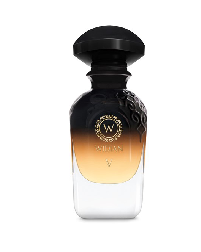

Description:
[u'bold yet sophist luscious yet play black v snappi vivaci utter love floral driven parfum extrait recal verv vigor creativ 1920 s black v open blast energi combin spici cinnamon crisp tart lemon peel juici peach sumptuous heart fragranc narcot tuberos given natur vibranc light bitter orang blossom bright solar accord lead rich never heavi base warm cedar smooth vanilla dollop sweet caramel widian s wondrous fragranc combin best east west we re thrill report black v also includ tantal joy mix past present']
Notes:
[u'lemon peach cinnamon tuberos orang blossom solar accord cedar caramel vanilla']
Revies:
There are 1 reviews
[u'peach brandi warm peach pie local honey dri powderi cedar pine perfect fall scent uniqu delici a delight retro femm orient wonder sparkl big and yes somewhat heavi cinnamon peach open fanfar inde bit callback bold sensual women fragranc 1930s 1940s no accid suppos note somewhat similar 1944 incarn bandit mani fragranc era sillag play around anoth win

In [12]:
inspect_perfume(perfume_id=325)

## Clean text

In [13]:
def stem_words(text):
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [14]:
df['description'] = df.description.apply(func=make_lower_case)
df['description'] = df.description.apply(func=remove_stop_words)
df['description'] = df.description.apply(func=remove_punctuation)
df['description'] = df.description.apply(func=stem_words)

In [15]:
df['notes'] = df.notes.apply(func=make_lower_case)
df['notes'] = df.notes.apply(func=remove_punctuation)
df['notes'] = df.notes.apply(func=stem_words)

In [16]:
df['reviews'] = df.reviews.apply(func=make_lower_case)
df['reviews'] = df.reviews.apply(func=remove_stop_words)
df['reviews'] = df.reviews.apply(func=remove_punctuation)
df['reviews'] = df.reviews.apply(func=stem_words)

In [17]:
df.head(1)

,perfume_id,title,image_url,description,notes,reviews
0,0,Lost Cherry Eau de Parfum by TOM FORD Private ...,https://www.luckyscent.com/images/products/635...,lost cherri contrast scent reveal tempt dichot...,black cherri accord bitter almond griott syrup...,tri tom ford scent madison avenu store blown a...


# TF-IDF Model

In [18]:
df['full_document'] = df['description'] + ' ' + df['notes'] + ' ' + df['reviews']

In [19]:
#Fit TFIDF 
#Learn vocabulary and tfidf from all style_ids.
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     #max_features=1000,
                     stop_words='english')
tf.fit(df['full_document'])

#Transform style_id products to document-term matrix.
tfidf_matrix = tf.transform(df['full_document'])
pickle.dump(tf, open("models/tfidf_model.pkl", "wb"))

print tfidf_matrix.shape

(2044, 8359)


In [20]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500)
latent_matrix = svd.fit_transform(tfidf_matrix)
pickle.dump(svd, open("models/svd_model.pkl", "wb"))

print latent_matrix.shape

(2044, 500)


In [21]:
n = 25 #pick components
#Use elbow and cumulative plot to pick number of components. 
#Need high ammount of variance explained. 
doc_labels = df.title
svd_feature_matrix = pd.DataFrame(latent_matrix[:,0:n] ,index=doc_labels)
print svd_feature_matrix.shape
svd_feature_matrix.head()

pickle.dump(svd_feature_matrix, open("models/lsa_embeddings.pkl", "wb"))

(2044, 25)


# Doc2Vec Model

Doc to vec preverves word order in the embeddings, so "I hate rose" and "I love rose" will be treated differently.

In [22]:
#Use reviews, descriptions, and notes for vocabulary 
reviews = df.reviews.values.tolist()
descriptions = df.description.values.tolist()
#notes = df.notes.values.tolist() #not using notes because sematics and order of list is not meaningfull. 

documents = []
for i in range(len(df)):
    mystr = reviews[i]
    mystr = mystr + descriptions[i]
    documents.append(re.sub("[^\w]", " ",  mystr).split())

In [23]:
print len(df)
print len(documents)

2044
2044


In [24]:
df.loc[278]

perfume_id                                                     325
title                             Black V Parfum Extrait by Widian
image_url        https://www.luckyscent.com/images/products/709...
description      bold yet sophist luscious yet play black v sna...
notes            lemon peach cinnamon tubero orang blossom sola...
reviews          peach brandi warm peach pie local honey dri po...
full_document    bold yet sophist luscious yet play black v sna...
Name: 278, dtype: object

In [25]:
formatted_documents = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]

model = gensim.models.doc2vec.Doc2Vec(vector_size=25, min_count=5, epochs=200, seed=0, window=3, dm=1)
model.build_vocab(formatted_documents)

In [26]:
%time model.train(formatted_documents, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 2min 46s, sys: 7.81 s, total: 2min 54s
Wall time: 1min 22s


In [27]:
fname = get_tmpfile("models/doc2vec_model")
model.save("models/doc2vec_model")
model = gensim.models.doc2vec.Doc2Vec.load("./models/doc2vec_model")

In [37]:
vector = model.infer_vector(doc_words=["this", "is", "a", "test"], epochs=50)
vector

array([-0.17191751, -0.8144744 , -0.06675702,  0.02599917, -0.16789891,
       -0.620023  ,  0.06134477, -0.3985729 ,  0.0493024 ,  0.3127219 ,
        0.16736154,  0.72309244, -0.480727  ,  0.36376455,  0.504173  ,
        0.26385027, -0.39857888,  0.24427186, -0.33695567,  0.17218815,
        0.26852754,  0.16747576, -0.28592792,  0.55985636,  0.35524458],
      dtype=float32)

In [31]:
doctovec_feature_matrix = pd.DataFrame(model.docvecs.vectors_docs, index=df.title)
print doctovec_feature_matrix.shape
doctovec_feature_matrix.head(3)
pickle.dump(doctovec_feature_matrix, open("models/doctovec_embeddings.pkl", "wb"))

(2044, 25)
